# Analyze geolocation

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

dir_in = './data_ori/'

In [2]:
events = pd.read_csv(dir_in + 'events.csv')
def age_group(sex, age):
    # Convert age column to age group
    #ageGroupsF = ['23-','24-26','27-28','29-32','33-42,''43+']
    #ageGroupsM = ['22-','23-26','27-28','29-31','32-38,''39+']

    if sex not in ['M','F']:
        ValueError('%s is not a valid gender' % sex)
        
    if age not in range(100):
        ValueError('%s is not a valid age' % age)
    
    if sex=="M":
        if age<=22:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=31:
            g = 3
        elif age<=38:
            g = 4
        else:
            g = 5
    elif sex=="F":
        if age<=23:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=32:
            g = 3
        elif age<=42:
            g = 4
        else:
            g = 5
    
    return g

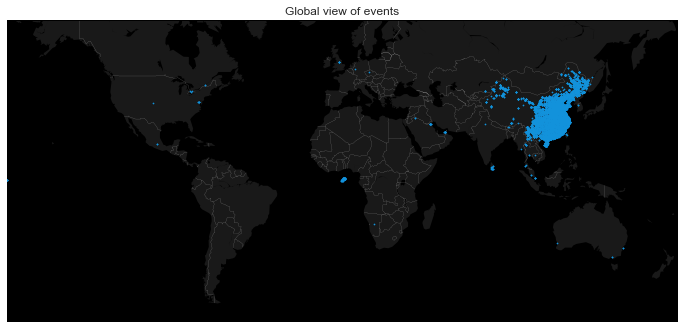

In [3]:
# Set up plot
df_events_sample = events.sample(n=100000)
plt.figure(1, figsize=(12,6))

# Mercator of World
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m1(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Global view of events")
plt.show()

In [166]:
# Events in Beijing
lon_min, lon_max = 116, 117
lat_min, lat_max = 39.75, 40.25

idx_beijing = (events["longitude"]>lon_min) &\
              (events["longitude"]<lon_max) &\
              (events["latitude"]>lat_min) &\
              (events["latitude"]<lat_max)

events_beijing = events[idx_beijing]


In [167]:
# Load the train data and join on the events
df_train = pd.read_csv(dir_in + 'gender_age_train.csv')
df_train['age_group'] = df_train[['gender','age']].apply(lambda x: age_group(x[0],x[1]), axis=1)

df_plot = pd.merge(df_train, events_beijing, on="device_id", how="inner")

df_m = df_plot[df_plot["gender"]=="M"]
df_f = df_plot[df_plot["gender"]=="F"]

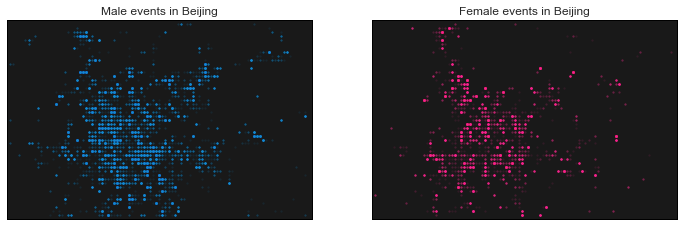

In [168]:
# Male/female plot
plt.figure(4, figsize=(12,6))

plt.subplot(121)
m4a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')
m4a.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m4a.drawmapboundary(fill_color='#000000')                # black background
m4a.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders
mxy = m4a(df_m["longitude"].tolist(), df_m["latitude"].tolist())
m4a.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.1, zorder=5)
plt.title("Male events in Beijing")

plt.subplot(122)
m4b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')
m4b.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m4b.drawmapboundary(fill_color='#000000')                # black background
m4b.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders
mxy = m4b(df_f["longitude"].tolist(), df_f["latitude"].tolist())
m4b.scatter(mxy[0], mxy[1], s=5, c="#fd3096", lw=0, alpha=0.1, zorder=5)
plt.title("Female events in Beijing")

plt.show()

In [196]:
# Make grid map with more female or more males
df_plot["lon_round"] = df_plot["longitude"].round(decimals=2)
df_plot["lat_round"] = df_plot["latitude"].round(decimals=2)
df_plot.loc[df_plot.gender=='M','gender']=1.0
df_plot.loc[df_plot.gender=='F','gender']=0.0

df_male = pd.pivot_table(df_plot,\
                        values="gender",\
                        index="lon_round",\
                        columns="lat_round",\
                        aggfunc=np.sum).astype(float)

df_cnt = pd.pivot_table(df_plot,\
                        values="gender",\
                        index="lon_round",\
                        columns="lat_round",\
                        aggfunc="count")

df_female = (df_cnt - df_male) / df_cnt
df_male = df_male / df_cnt

df_diff = df_male - df_female

In [197]:
df_male.head(5)

lat_round,39.76,39.77,39.78,39.79,39.8,39.81,39.82,39.83,39.84,39.85,...,40.15,40.16,40.17,40.18,40.19,40.2,40.21,40.22,40.23,40.24
lon_round,,,,,,,,,,,,,,,,,,,,,
116.01,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
116.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN


In [171]:
df_female.head(5)


lat_round,39.76,39.77,39.78,39.79,39.8,39.81,39.82,39.83,39.84,39.85,...,40.15,40.16,40.17,40.18,40.19,40.2,40.21,40.22,40.23,40.24
lon_round,,,,,,,,,,,,,,,,,,,,,
116.01,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
116.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


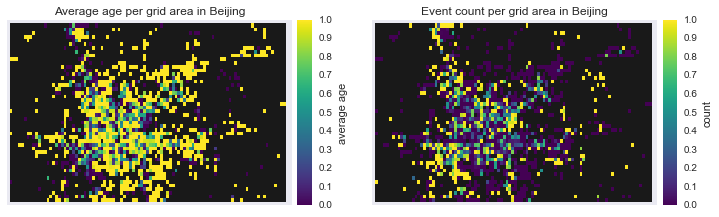

In [172]:
# Age plot
plt.figure(5, figsize=(12,6))

# Plot avg age per grid
plt.subplot(121)
m5a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')      
# Construct a heatmap
lons = df_male.index.values
lats = df_male.columns.values
x, y = np.meshgrid(lons, lats) 
px, py = m5a(x, y) 
data_values = df_male.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5a.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5a.colorbar().set_label("average age")
plt.title("Average age per grid area in Beijing")

# Plot count per grid
plt.subplot(122)
m5b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')      
# Construct a heatmap 
data_values = df_female.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event count per grid area in Beijing")

plt.show()

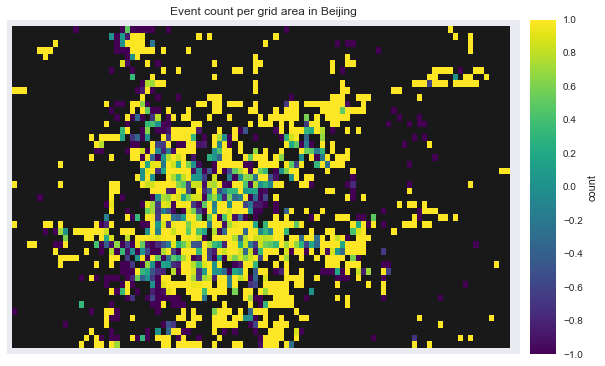

In [173]:
# Plot count per grid
plt.figure(6, figsize=(12,6))
m5b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')      
# Construct a heatmap 
data_values = df_diff.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event count per grid area in Beijing")

plt.show()

In [174]:
# Make a pivot table showing average age per area of a grid, also store the counts
df_plot["lon_round"] = df_plot["longitude"].round(decimals=2)
df_plot["lat_round"] = df_plot["latitude"].round(decimals=2)

df_age = pd.pivot_table(df_plot,\
                        values="age_group",\
                        index="lon_round",\
                        columns="lat_round",\
                        aggfunc=np.mean)

df_cnt = pd.pivot_table(df_plot,\
                        values="age_group",\
                        index="lon_round",\
                        columns="lat_round",\
                        aggfunc="count")


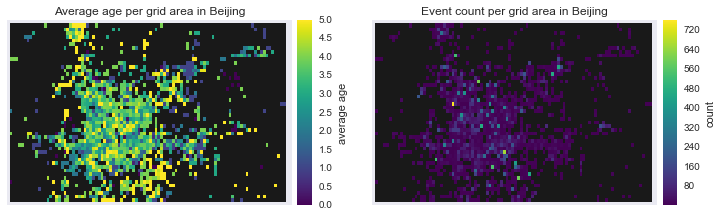

In [175]:
# Age plot
plt.figure(5, figsize=(12,6))

# Plot avg age per grid
plt.subplot(121)
m5a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')      
# Construct a heatmap
lons = df_age.index.values
lats = df_age.columns.values
x, y = np.meshgrid(lons, lats) 
px, py = m5a(x, y) 
data_values = df_age.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5a.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5a.colorbar().set_label("average age")
plt.title("Average age per grid area in Beijing")

# Plot count per grid
plt.subplot(122)
m5b = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')      
# Construct a heatmap 
data_values = df_cnt.values
masked_data = np.ma.masked_invalid(data_values.T)
cmap = plt.cm.viridis
cmap.set_bad(color="#191919")
# Plot the heatmap
m5b.pcolormesh(px, py, masked_data, cmap=cmap, zorder=5)
m5b.colorbar().set_label("count")
plt.title("Event count per grid area in Beijing")

plt.show()


In [180]:
# Try to smooth and interpolate age map
from scipy import interpolate
def my_interp(X, Y, Z, x, y, spn=3):
    xs,ys = map(np.array,(x,y))
    z = np.zeros(xs.shape)
    for i,(x,y) in enumerate(zip(xs,ys)):
        # get the indices of the nearest x,y
        xi = np.argmin(np.abs(X[0,:]-x))
        yi = np.argmin(np.abs(Y[:,0]-y))
        xlo = max(xi-spn, 0)
        ylo = max(yi-spn, 0)
        xhi = min(xi+spn, X[0,:].size)
        yhi = min(yi+spn, Y[:,0].size)
        # make slices of X,Y,Z that are only a few items wide
        nX = X[xlo:xhi, ylo:yhi]
        nY = Y[xlo:xhi, ylo:yhi]
        nZ = Z[xlo:xhi, ylo:yhi]
        intp = interpolate.interp2d(nX, nY, nZ)
        z[i] = intp(x,y)[0]
    return z

In [181]:
N = 1000
X,Y = np.meshgrid(np.arange(N), np.arange(N))
Z = np.random.random((N, N))

print my_interp(X, Y, Z, [13.2, 999.9], [0.01, 45.3])

[ 0.69106688  0.04148882]


### Validation of gender map
Test whether estimation of gender based on these maps works.

In [182]:
age_map_m = df_male
age_map_f = df_female

to_do = df_plot.groupby('device_id')['lon_round','lat_round'].median()
age_map_m.index

def find_age(lon_round, lat_round):
    if lon_round in age_map_m.index and lat_round in age_map_m.columns:
        return age_map_m.loc[lon_round, lat_round]
    return None
def find_age_f(lon_round, lat_round):
    if lon_round in age_map_f.index and lat_round in age_map_f.columns:
        return age_map_f.loc[lon_round, lat_round]
    return None
print find_age(9999,999)

None


In [183]:
gender_based = pd.DataFrame()
gender_based['gender_male'] = to_do[['lon_round', 'lat_round']]\
    .apply(lambda x: find_age(x[0],x[1]), axis=1)
gender_based['gender_female'] = to_do[['lon_round', 'lat_round']] \
    .apply(lambda x: find_age_f(x[0],x[1]), axis=1)
#gender_based['gender']=df_plot['gender']



In [184]:
print gender_based.head()
print gender_based.shape
gender_based = pd.merge(gender_based, df_train, right_on="device_id", how="inner", left_index=True)
print gender_based.shape
print gender_based.head()

                      gender_male  gender_female
device_id                                       
-9201141107731295908     0.098361       0.901639
-9162848328412258499          NaN            NaN
-9142376725008534333     1.000000       0.000000
-9101962973644735950     0.673077       0.326923
-9099079396602537376     0.837209       0.162791
(626, 2)
(626, 7)
       gender_male  gender_female            device_id gender  age   group  \
65433     0.098361       0.901639 -9201141107731295908      F   27  F27-28   
12091          NaN            NaN -9162848328412258499      M   24  M23-26   
74456     1.000000       0.000000 -9142376725008534333      M   56    M39+   
52326     0.673077       0.326923 -9101962973644735950      F   31  F29-32   
65988     0.837209       0.162791 -9099079396602537376      M   27  M27-28   

       age_group  
65433          2  
12091          1  
74456          5  
52326          3  
65988          2  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c812f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13e19ed10>]], dtype=object)

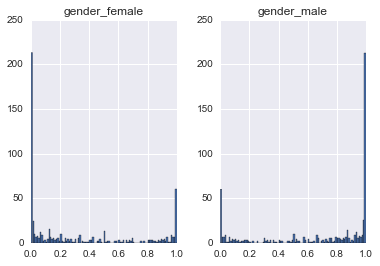

In [185]:
gender_based[['gender_male','gender_female']].hist(bins=100)

In [186]:
gender_based.gender[gender_based.gender=='M']=1
gender_based.gender[gender_based.gender=='F']=0

def accuracy(delta):
    #gender_based.gender_male = gender_based.gender_male>delta
    #gender_based.gender_female = gender_based.gender_female>delta
    
    print float(sum( (gender_based['gender_male']>delta)==gender_based['gender'])) / gender_based.shape[0]
    print float(sum( (gender_based['gender_female']<delta)==gender_based['gender'])) / gender_based.shape[0]

/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [187]:
print gender_based.shape
print "Benchmark: %f" % (float(sum( gender_based['gender'])) / gender_based.shape[0])
for i in np.arange(0,1.1,0.1):
    print i
    accuracy(i)

(626, 7)
Benchmark: 0.666134
0.0
0.73642172524
0.333865814696
0.1
0.784345047923
0.76357827476
0.2
0.800319488818
0.790734824281
0.3
0.798722044728
0.803514376997
0.4
0.805111821086
0.813099041534
0.5
0.817891373802
0.817891373802
0.6
0.813099041534
0.803514376997
0.7
0.803514376997
0.798722044728
0.8
0.790734824281
0.800319488818
0.9
0.76357827476
0.784345047923
1.0
0.333865814696
0.73642172524


### Validation of age map

In [188]:
age_map = df_age
age_cnt = df_cnt
to_do = df_plot.groupby('device_id')['lon_round','lat_round'].median()
age_map_m.index

def find_age(lon_round, lat_round):
    if lon_round in age_map.index and lat_round in age_map.columns:
        if df_cnt.loc[lon_round, lat_round]>100:
            return age_map.loc[lon_round, lat_round]
    return None
print find_age(9999,999)

None


In [189]:
age_based = pd.DataFrame()
age_based['age_group'] = to_do[['lon_round', 'lat_round']]\
    .apply(lambda x: find_age(x[0],x[1]), axis=1)

In [190]:
print age_based.head()
print age_based.shape
age_based = pd.merge(age_based, df_train, right_on="device_id", how="inner", left_index=True)
print age_based.shape
print age_based.head()



                      age_group
device_id                      
-9201141107731295908        NaN
-9162848328412258499        NaN
-9142376725008534333        NaN
-9101962973644735950        NaN
-9099079396602537376   3.209302
(626, 1)
(626, 6)
       age_group_x            device_id gender  age   group  age_group_y
65433          NaN -9201141107731295908      F   27  F27-28            2
12091          NaN -9162848328412258499      M   24  M23-26            1
74456          NaN -9142376725008534333      M   56    M39+            5
52326          NaN -9101962973644735950      F   31  F29-32            3
65988     3.209302 -9099079396602537376      M   27  M27-28            2


       age_group_x            device_id gender  age   group  age_group_y
65433          NaN -9201141107731295908      F   27  F27-28            2
12091          NaN -9162848328412258499      M   24  M23-26            1
74456          NaN -9142376725008534333      M   56    M39+            5
52326          NaN -9101962973644735950      F   31  F29-32            3
65988     3.209302 -9099079396602537376      M   27  M27-28            2
63853     3.815574 -9097034653448679048      M   31  M29-31            3
39818          NaN -9073407886058867537      M   26  M23-26            1
7005           NaN -9036581639226036355      M   53    M39+            5
30572          NaN -8952541363097602127      M   28  M27-28            2
12956     3.921569 -8878683891449905355      M   33  M32-38            4
1.22057571433
65433     NaN
12091     NaN
74456     NaN
52326     NaN
65988    1.21
63853    0.82
39818     NaN
7005      NaN
30572     NaN
12956   -0.08
63238     NaN
20219     NaN
17157     NaN
2

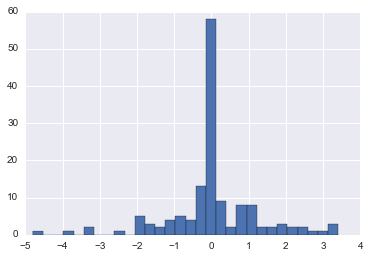

In [191]:
print age_based.head(10)
(age_based['age_group_x']-age_based['age_group_y']).round(decimals=2).hist(bins=30)
print (age_based['age_group_x']-age_based['age_group_y']).round(decimals=2).std()
print (age_based['age_group_x']-age_based['age_group_y']).round(decimals=2).head(30)

# Investigate whether men travel more

In [89]:
diff = df_plot[df_plot.longitude>0].groupby(['gender','device_id']).longitude.max() \
    - df_plot[df_plot.longitude>0].groupby(['gender','device_id']).longitude.min()
diff2 = df_plot[df_plot.longitude>0].groupby(['gender','device_id']).longitude.std()
diff3 = df_plot[df_plot.longitude>0].groupby(['gender','device_id']).longitude.nunique()

In [90]:
print diff.reset_index().groupby(['gender']).longitude.mean()
print diff2.reset_index().groupby(['gender']).longitude.mean()
print diff3.reset_index().groupby(['gender']).longitude.mean()


gender
0.0    1.934787
1.0    2.360315
Name: longitude, dtype: float64
gender
0.0    0.679801
1.0    0.878242
Name: longitude, dtype: float64
gender
0.0    2.485004
1.0    3.044460
Name: longitude, dtype: float64


In [144]:
# How many events have zero lon or lat coordinates
df_plot_no_zero = df_plot[ (df_plot.latitude>0) & (df_plot.longitude>0)]
print df_plot.shape
print df_plot_no_zero.shape
print float(df_plot_no_zero.shape[0])/df_plot.shape[0]

# 30% of events has zero latitude or zero longitude

(1215595, 11)
(858777, 11)
0.706466380661


In [147]:
# How many devices are left?
print df_plot.groupby('device_id').size().shape
print df_plot_no_zero.groupby('device_id').size().shape
# total devices is 75k, so that's not a lot

(23309,)
(11949,)


In [103]:
# Removing zeros is important, otherwise standard deviations explode
lon_std = df_plot[df_plot.longitude>0].groupby(['gender','device_id']).longitude.std().to_frame('lon std')
lat_std = df_plot[df_plot.latitude>0].groupby(['gender','device_id']).latitude.std().to_frame('lat std')

In [104]:
lon_std.head()

lon std
gender device_id                     
0.0    -9221026417907250887  0.004255
       -9212424538588397592  0.000000
       -9201141107731295908  0.018037
       -9185683155567867976  0.000000
       -9174409012143247712  0.000000

In [105]:
lat_std.head()

lat std
gender device_id                     
0.0    -9221026417907250887  0.004187
       -9212424538588397592  0.000000
       -9201141107731295908  0.030853
       -9185683155567867976  0.000000
       -9174409012143247712  0.000000

In [133]:
print lon_std.unstack('gender').mean() / lon_std.unstack('gender').mean().max()
print lat_std.unstack('gender').mean() / lat_std.unstack('gender').mean().max()
print lon_std.shape
print lat_std.shape

         gender
lon std  0.0       0.774047
         1.0       1.000000
dtype: float64
         gender
lat std  0.0       0.848502
         1.0       1.000000
dtype: float64
(11958, 1)
(11962, 1)


Conclusion: men travel a bit more than women, but we can calculate this only on a small part of the devices.

In [114]:
lat_std['lat std'][lat_std['lat std']>0].unstack('gender').head()

gender,0.0,1.0
device_id,,
-9221026417907250887,0.004187,NaN
-9220061629197656378,NaN,0.018324
-9218769147970107256,NaN,0.024630
-9206202041936929793,NaN,0.009739
-9201141107731295908,0.030853,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e75f6d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1407731d0>]], dtype=object)

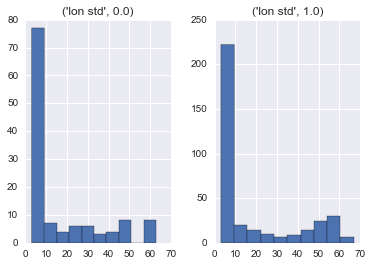

In [154]:
lon_std[lon_std>3].unstack('gender').hist()
# We are not talking about a lot of devices here!